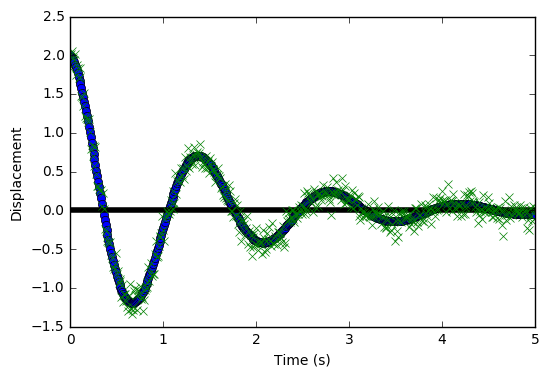

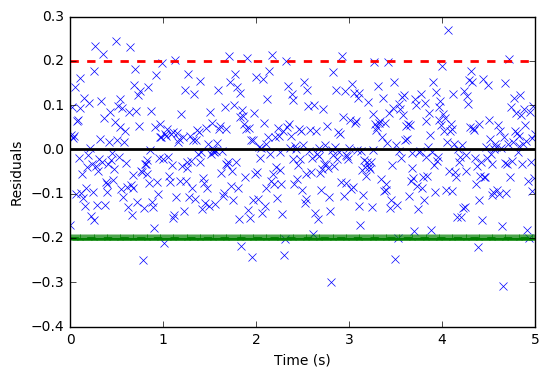

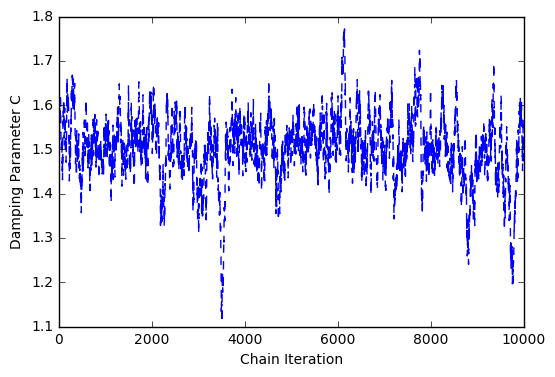

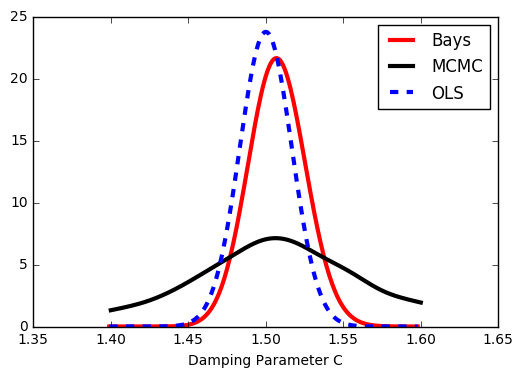

In [34]:
#                      spring_mcmc_C.m

# This code illustrates the implementation of the Metropolis algorithm
# in Example 8.7, Case i.

# Input true stiffness and damping parameters and error variance

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import gaussian_kde

K = 20.50
C = 1.5
C_old = C
C0 = C
sigma = .1
var = sigma**2
N = 10000

factor = np.sqrt(K - C**2/4)
denom = np.sqrt(4*K - C**2)

# Construct solution on [0,5], the analytic sensitivity relations, and
# the observations, which include the error.

t = np.array([x/100 for x in range(501)])
n = t.size

y = 2*np.exp((-C/2)*np.array(t))*np.cos(factor*np.array(t))
y0=y
dydc = np.exp((-C/2)*np.array(t))*(((C/denom)*(np.array(t)))*np.sin(factor*np.array(t))-np.cos(factor*np.array(t)))

error = sigma*np.random.randn(t.size)
obs = y + error

# Construct the sensitivity matrix chi and covariance matrix V.

chi = dydc.T
J = np.matmul(dydc.T,dydc)
V = 1/J
V=V*var
#R = np.linalg.cholesky(V)
R=0.0183

SS_old = np.matmul((obs-y),(obs-y).T)

# Construct a Metropolis chain of lenth N

Cvals=np.zeros((N))
for i in range(N):
    z = np.random.randn(1)
    C_new = C_old + R*z
    factor = np.sqrt(K - C_new**2/4)
    y_new = 2*np.exp(-C_new*np.array(t)/2)*np.cos(factor*np.array(t))
    u_alpha = np.random.randn(1)
    SS_new = np.matmul((obs-y_new),(obs-y_new).T)
    term = np.exp(-0.5*np.array((SS_new-SS_old)/var))
    alpha = min(1,term)
    if(u_alpha < alpha):
       Cvals[i] = C_new
       C_old = C_new
       SS_old = SS_new
    else:
       Cvals[i] = C_old

# Use kde to construct the density for C from the Metropolis chain

range_C = max(Cvals) - min(Cvals)
C_min = min(Cvals)-range_C/10
C_max = max(Cvals)+range_C/10

def frange(start, stop, step):
        i = start
        while i < stop:
            yield i
            i += step
            
            
def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]


# Construct the posterior density directly by approximating Bayes' rule using a
# a midpoint quadrature rule.

h = .001
Nq = int(0.2/h) 
quadpt=np.zeros((Nq))
posterior=np.zeros((Nq))
C_post_axis=np.zeros((Nq))
for i in range(Nq):
    C = 1.4 + i*h-h
    factor = np.sqrt(K - C**2/4) 
    y = 2*np.exp(-C*t/2)*np.cos(factor*t)
    SS = np.matmul((obs-y),(obs-y).T)
    for j in range(Nq):
        Cq = 1.4 + (j-1)*h;
        factor = np.sqrt(K - Cq**2/4) 
        yq = 2*np.exp(-Cq*t/2)*np.cos(factor*t)
        SSq = np.matmul((obs-yq),(obs-yq).T)
        quadpt[j] = np.exp(-.5*(SSq-SS)/var)
  
    posterior[i] = 1/(h*sum(quadpt))
    C_post_axis[i] = C

# Construct the asymptotic normal sampling distribution.

mean = h*sum(C_post_axis*posterior)
sample_dist=mlab.normpdf(C_post_axis,C0,np.sqrt(V))


# Plot results. 

f = plt.figure()
plt.plot(t,y0,'o',linewidth=6)
plt.plot(t,0*np.array(y0),'k',linewidth=4)
plt.plot(t,obs,'x',linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Displacement')
plt.show()

f = plt.figure()
plt.plot(t,error,'x',linewidth=2)
plt.plot(t,0*np.array(y),'k',linewidth=2)
plt.plot(t,2*sigma*np.ones((t.size)),'--r',linewidth=2)
plt.plot(t,-2*sigma*np.ones((t.size)),'--2',linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Residuals')
plt.show()

 
f = plt.figure()
plt.plot(Cvals,'--',linewidth=1)
plt.xlabel('Chain Iteration')
plt.ylabel('Damping Parameter C')
plt.show()


kde1 = gaussian_kde(Cvals, 'silverman')
#x_eval = np.linspace(1.3774, 1.6318, num=16384)
x_eval = np.linspace(1.4, 1.6, num=16384)
ttt=frange(1, 2**14, 1)
f = plt.figure()
plt.plot(C_post_axis,posterior,'-r', label='Bays',linewidth=3)
plt.plot(x_eval,kde1(x_eval),'-k', label='MCMC', linewidth=3) 
plt.plot(C_post_axis,sample_dist,'b--', label='OLS',linewidth=3) 
plt.legend()
plt.xlabel('Damping Parameter C')
plt.show()

